### Update the Socure SQL Query
---

In [1]:
import pandas as pd
import sys, os, json, s3fs
import matplotlib.pyplot as plt
plt.style.use("seaborn")
sys.path.insert(1, "../../")

from rdsutils.query import query_postgres
import src.monitoring.utils as mu

%load_ext autoreload
%autoreload 2

In [ ]:
%%time 

query_old = """
-- Query for Socure data pull
with map as (select distinct thirdparty_raw_id, event_id
             from decision)
select e.user_id,
       tpr.created_dt,
       case when tpr.response::jsonb->'fraud'#>'{scores, 0}'->>'version'='3.0' then tpr.response::json->'fraud'#>'{scores, 0}'->>'score' else tpr.response::json->'fraud'#>'{scores, 1}'->>'score' end as fraud_score_1,
       case when tpr.response::jsonb->'fraud'#>'{scores, 0}'->>'version'='1.0' then tpr.response::json->'fraud'#>'{scores, 0}'->>'score' else tpr.response::json->'fraud'#>'{scores, 1}'->>'score' end as fraud_score_2,
       tpr.response::jsonb->'addressRisk'->>'score' as address_risk_score,        
       tpr.response::jsonb->'emailRisk'->>'score' as email_risk_score,
       tpr.response::jsonb->'phoneRisk'->>'score' as phone_risk_score,
       tpr.response::jsonb->'nameAddressCorrelation'->>'score' as name_address_correlation,
       tpr.response::jsonb->'nameEmailCorrelation'->>'score' as name_email_correlation,
       tpr.response::jsonb->'namePhoneCorrelation'->>'score' as name_phone_correlation,
       tpr.response::jsonb->'social'->>'profilesFound' as social_profiles_found
from event e
join map on e.event_id=map.event_id
join thirdparty_raw tpr on tpr.thirdparty_raw_id = map.thirdparty_raw_id
join thirdparty_provider tpp on tpr.thirdparty_provider_id=tpp.thirdparty_provider_id
where e.kob='BANKING' and tpp.code='SOCURE'
"""

df_old = query_postgres(query=query_old, port=15722, database="sofi_fraud")

In [ ]:
%%time 

query_new = """
with map as (select distinct thirdparty_raw_id, event_id
             from decision)
select e.user_id,
       tpr.created_dt,
       case when tpr.response::jsonb->'fraud'#>'{scores, 0}'->>'version'='3.0' then tpr.response::json->'fraud'#>'{scores, 0}'->>'score' else tpr.response::json->'fraud'#>'{scores, 1}'->>'score' end as fraud_score_1_v1,
       case when tpr.response::jsonb->'fraud'#>'{scores, 0}'->>'version'='1.0' then tpr.response::json->'fraud'#>'{scores, 0}'->>'score' else tpr.response::json->'fraud'#>'{scores, 1}'->>'score' end as fraud_score_2_v1,
       case when tpr.response::jsonb->'fraud'#>'{scores, 0}'->>'name'='generic' then tpr.response::json->'fraud'#>'{scores, 0}'->>'score' 
          when tpr.response::jsonb->'fraud'#>'{scores, 1}'->>'name'='generic' then tpr.response::json->'fraud'#>'{scores, 1}'->>'score'
          else null end as fraud_score_1_v2,
       case when tpr.response::jsonb->'fraud'#>'{scores, 0}'->>'name'='generic' then tpr.response::json->'fraud'#>'{scores, 0}'->>'version' 
          when tpr.response::jsonb->'fraud'#>'{scores, 1}'->>'name'='generic' then tpr.response::json->'fraud'#>'{scores, 1}'->>'version'
          else null end as fraud_score_1_version,
       case when tpr.response::jsonb->'fraud'#>'{scores, 0}'->>'name'='sigma' then tpr.response::json->'fraud'#>'{scores, 0}'->>'score' 
          when tpr.response::jsonb->'fraud'#>'{scores, 1}'->>'name'='sigma' then tpr.response::json->'fraud'#>'{scores, 1}'->>'score'
          else null end as fraud_score_2_v2,
       case when tpr.response::jsonb->'fraud'#>'{scores, 0}'->>'name'='sigma' then tpr.response::json->'fraud'#>'{scores, 0}'->>'version' 
          when tpr.response::jsonb->'fraud'#>'{scores, 1}'->>'name'='sigma' then tpr.response::json->'fraud'#>'{scores, 1}'->>'version'
          else null end as fraud_score_2_version,
       tpr.response::jsonb->'addressRisk'->>'score' as address_risk_score,        
       tpr.response::jsonb->'emailRisk'->>'score' as email_risk_score,
       tpr.response::jsonb->'phoneRisk'->>'score' as phone_risk_score,
       tpr.response::jsonb->'nameAddressCorrelation'->>'score' as name_address_correlation,
       tpr.response::jsonb->'nameEmailCorrelation'->>'score' as name_email_correlation,
       tpr.response::jsonb->'namePhoneCorrelation'->>'score' as name_phone_correlation,
       tpr.response::jsonb->'social'->>'profilesFound' as social_profiles_found
from event e
join map on e.event_id=map.event_id
join thirdparty_raw tpr on tpr.thirdparty_raw_id = map.thirdparty_raw_id
join thirdparty_provider tpp on tpr.thirdparty_provider_id=tpp.thirdparty_provider_id
where e.kob='BANKING' and tpp.code='SOCURE'
"""

df_new = query_postgres(query=query_new, port=15722, database="sofi_fraud")

In [8]:
df_old.shape, df_new.shape

((2313545, 11), (2313431, 15))

In [9]:
%%time
df_old.to_feather("../../artifacts/data-dump/socure_scores_old.feather")
df_new.to_feather("../../artifacts/data-dump/socure_scores_new.feather")

CPU times: user 8.72 s, sys: 901 ms, total: 9.62 s
Wall time: 12.6 s


### Look at the values

In [ ]:
df_old = pd.read_parquet("../../artifacts/data-dump/socure_scores_old.feather")
df_new = pd.read_parquet("../../artifacts/data-dump/socure_scores_new.feather")

In [10]:
df_old.columns

Index(['user_id', 'created_dt', 'fraud_score_1', 'fraud_score_2',
       'address_risk_score', 'email_risk_score', 'phone_risk_score',
       'name_address_correlation', 'name_email_correlation',
       'name_phone_correlation', 'social_profiles_found'],
      dtype='object')

In [11]:
df_new.columns

Index(['user_id', 'created_dt', 'fraud_score_1_v1', 'fraud_score_2_v1',
       'fraud_score_1_v2', 'fraud_score_1_version', 'fraud_score_2_v2',
       'fraud_score_2_version', 'address_risk_score', 'email_risk_score',
       'phone_risk_score', 'name_address_correlation',
       'name_email_correlation', 'name_phone_correlation',
       'social_profiles_found'],
      dtype='object')

In [ ]:
df_ = df_new
df_[f"missing_fraud_score_2_v2"] = df_["fraud_score_2_v2"].isna()
df_[f"missing_fraud_score_2_v1"] = df_["fraud_score_2_v1"].isna()
grouper = pd.Grouper(key='created_dt', freq="1M")
df_ = df_.groupby(grouper)[["missing_fraud_score_2_v1",
                            "missing_fraud_score_2_v2"]].agg(["mean"])


In [20]:
display(df_.loc["2020-01-01":])

,missing_fraud_score_2_v1,missing_fraud_score_2_v2
,mean,mean
created_dt,,
2020-01-31 00:00:00+00:00,0.033935,0.033935
2020-02-29 00:00:00+00:00,0.013268,0.013268
2020-03-31 00:00:00+00:00,0.032201,0.032201
2020-04-30 00:00:00+00:00,0.042921,0.042921
2020-05-31 00:00:00+00:00,0.037424,0.037424
2020-06-30 00:00:00+00:00,0.035165,0.035165
2020-07-31 00:00:00+00:00,0.015401,0.015401
2020-08-31 00:00:00+00:00,0.012057,0.012057


<AxesSubplot:xlabel='created_dt'>

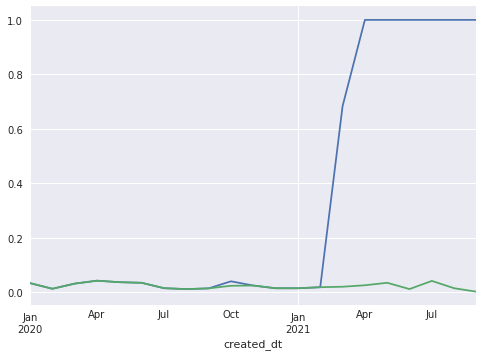

In [24]:
df_.loc["2020-01-01":][("missing_fraud_score_2_v1", "mean")].plot()
df_.loc["2020-01-01":][("missing_fraud_score_2_v2", "mean")].plot()

In [25]:
# do the values align?
df_new.shape, df_old.shape

((2313431, 17), (2313545, 11))

In [26]:
df_old.head()

,user_id,created_dt,fraud_score_1,fraud_score_2,address_risk_score,email_risk_score,phone_risk_score,name_address_correlation,name_email_correlation,name_phone_correlation,social_profiles_found
0,17834074,2021-06-28 16:26:59.374797+00:00,None,None,0.217,0.907,0.371,0.6849,0.507,0.9999,None
1,17140605,2021-05-05 02:49:54.738524+00:00,None,None,0.771,0.284,0.782,0.8194,0.9999,0.9547,None
2,13582309,2019-04-10 18:59:37.871082+00:00,0.0498,0.637,0.651,0.774,0.661,0.01,0.9935,0.9984,[]
3,19941740,2021-09-07 23:55:33.943728+00:00,None,None,0,0.649,0.334,0,0.507,0.9999,None
4,12567286,2020-12-21 14:20:45.895950+00:00,0.0909,0.023,0.396,0.427,0.244,0.8194,0.9979,0.9999,[]


In [27]:
df_new.head()

,user_id,created_dt,fraud_score_1_v1,fraud_score_2_v1,fraud_score_1_v2,fraud_score_1_version,fraud_score_2_v2,fraud_score_2_version,address_risk_score,email_risk_score,phone_risk_score,name_address_correlation,name_email_correlation,name_phone_correlation,social_profiles_found,missing_fraud_score_2_v2,missing_fraud_score_2_v1
0,17834074,2021-06-28 16:26:59.374797+00:00,None,None,None,None,0.618,2.0,0.217,0.907,0.371,0.6849,0.507,0.9999,None,False,True
1,17140605,2021-05-05 02:49:54.738524+00:00,None,None,None,None,0.018,2.0,0.771,0.284,0.782,0.8194,0.9999,0.9547,None,False,True
2,13582309,2019-04-10 18:59:37.871082+00:00,0.0498,0.637,0.0498,3.0,0.637,1.0,0.651,0.774,0.661,0.01,0.9935,0.9984,[],False,False
3,19941740,2021-09-07 23:55:33.943728+00:00,None,None,None,None,0.619,2.0,0,0.649,0.334,0,0.507,0.9999,None,False,True
4,12567286,2020-12-21 14:20:45.895950+00:00,0.0909,0.023,0.0909,3.0,0.023,2.0,0.396,0.427,0.244,0.8194,0.9979,0.9999,[],False,False


### verify updated query makes sense

In [44]:
socure_df = pd.read_feather("../../data/processed/processed_1632511182/socure_1632511182.feather")
socure_trnx_df = pd.read_feather("../../data-transactional/processed/processed_1632511509/socure_1632511509.feather")

for col in ["fraud_score_2", "fraud_score_2_v1",
            "fraud_score_1", "fraud_score_1_v1"]:
    socure_df[col] = socure_df[col].astype(float)
    socure_trnx_df[col] = socure_trnx_df[col].astype(float)

In [45]:
socure_df.head()

,user_id,created_dt,fraud_score_1_v1,fraud_score_2_v1,fraud_score_1,fraud_score_1_version,fraud_score_2,fraud_score_2_version,address_risk_score,email_risk_score,phone_risk_score,name_address_correlation,name_email_correlation,name_phone_correlation,social_profiles_found,nr_social_profiles_found
0,17834074,2021-06-28 16:26:59.374797,NaN,NaN,NaN,None,0.618,2.0,0.217,0.907,0.371,0.6849,0.5070,0.9999,None,NaN
1,17140605,2021-05-05 02:49:54.738524,NaN,NaN,NaN,None,0.018,2.0,0.771,0.284,0.782,0.8194,0.9999,0.9547,None,NaN
2,13582309,2019-04-10 18:59:37.871082,0.0498,0.637,0.0498,3.0,0.637,1.0,0.651,0.774,0.661,0.0100,0.9935,0.9984,[],0.0
3,19941740,2021-09-07 23:55:33.943728,NaN,NaN,NaN,None,0.619,2.0,0.000,0.649,0.334,0.0000,0.5070,0.9999,None,NaN
4,12567286,2020-12-21 14:20:45.895950,0.0909,0.023,0.0909,3.0,0.023,2.0,0.396,0.427,0.244,0.8194,0.9979,0.9999,[],0.0


In [46]:
socure_trnx_df.head()

,user_id,created_dt,fraud_score_1_v1,fraud_score_2_v1,fraud_score_1,fraud_score_1_version,fraud_score_2,fraud_score_2_version,address_risk_score,email_risk_score,phone_risk_score,name_address_correlation,name_email_correlation,name_phone_correlation,social_profiles_found,nr_social_profiles_found
0,17834074,2021-06-28 16:26:59.374797,NaN,NaN,NaN,None,0.618,2.0,0.217,0.907,0.371,0.6849,0.5070,0.9999,None,NaN
1,17140605,2021-05-05 02:49:54.738524,NaN,NaN,NaN,None,0.018,2.0,0.771,0.284,0.782,0.8194,0.9999,0.9547,None,NaN
2,13582309,2019-04-10 18:59:37.871082,0.0498,0.637,0.0498,3.0,0.637,1.0,0.651,0.774,0.661,0.0100,0.9935,0.9984,[],0.0
3,19941740,2021-09-07 23:55:33.943728,NaN,NaN,NaN,None,0.619,2.0,0.000,0.649,0.334,0.0000,0.5070,0.9999,None,NaN
4,12567286,2020-12-21 14:20:45.895950,0.0909,0.023,0.0909,3.0,0.023,2.0,0.396,0.427,0.244,0.8194,0.9979,0.9999,[],0.0


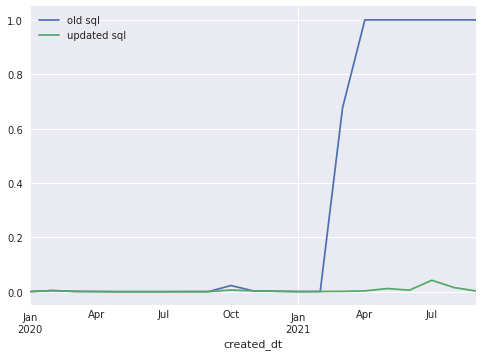

In [47]:
df_ = socure_df
df_[f"missing_fraud_score_2"] = df_["fraud_score_2"].isna()
df_[f"missing_fraud_score_2_v1"] = df_["fraud_score_2_v1"].isna()
grouper = pd.Grouper(key='created_dt', freq="1M")
df_ = df_.groupby(grouper)[["missing_fraud_score_2_v1",
                            "missing_fraud_score_2"]].agg(["mean"])
df_.loc["2020-01-01":][("missing_fraud_score_2_v1", "mean")].plot(label="old sql")
df_.loc["2020-01-01":][("missing_fraud_score_2", "mean")].plot(label="updated sql")
plt.legend()

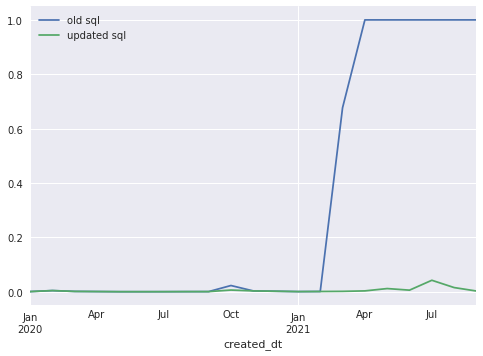

In [48]:
df_ = socure_trnx_df
df_[f"missing_fraud_score_2"] = df_["fraud_score_2"].isna()
df_[f"missing_fraud_score_2_v1"] = df_["fraud_score_2_v1"].isna()
grouper = pd.Grouper(key='created_dt', freq="1M")
df_ = df_.groupby(grouper)[["missing_fraud_score_2_v1",
                            "missing_fraud_score_2"]].agg(["mean"])
df_.loc["2020-01-01":][("missing_fraud_score_2_v1", "mean")].plot(label="old sql")
df_.loc["2020-01-01":][("missing_fraud_score_2", "mean")].plot(label="updated sql")
plt.legend()

#### Verify the produced fraud_score_2s align with the old distribution?
- Yes!

,same_fraud_score_2
,mean
created_dt,
2020-01-31,1.000000
2020-02-29,1.000000
2020-03-31,1.000000
2020-04-30,1.000000
2020-05-31,1.000000
2020-06-30,1.000000
2020-07-31,1.000000
2020-08-31,1.000000


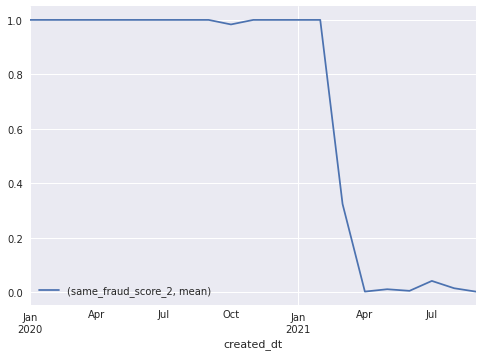

In [49]:
df_ = socure_df
df_["same_fraud_score_2"] = ((df_["fraud_score_2"] == df_["fraud_score_2_v1"])
                             | (df_["fraud_score_2"].isna() & df_["fraud_score_2_v1"].isna())).astype(bool)
df_ = df_.groupby(grouper)[["same_fraud_score_2"]].agg(["mean"])
df_.loc["2020-01-01":][("same_fraud_score_2", "mean")].plot()
plt.legend()
display(df_.loc["2020-01-01":])

,same_fraud_score_1
,mean
created_dt,
2020-01-31,1.000000
2020-02-29,1.000000
2020-03-31,1.000000
2020-04-30,1.000000
2020-05-31,1.000000
2020-06-30,1.000000
2020-07-31,1.000000
2020-08-31,1.000000


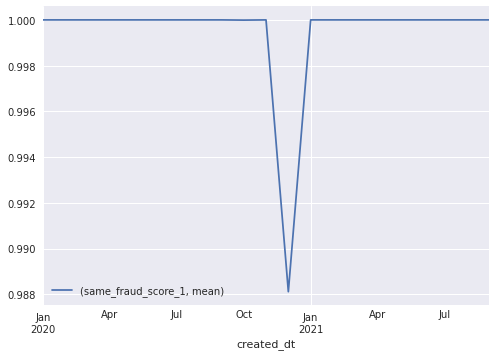

In [59]:
df_ = socure_df
df_["same_fraud_score_1"] = ((df_["fraud_score_1"] == df_["fraud_score_1_v1"])
                             | (df_["fraud_score_1"].isna() & df_["fraud_score_1_v1"].isna())).astype(bool)
df_ = df_.groupby(grouper)[["same_fraud_score_1"]].agg(["mean"])
df_.loc["2020-01-01":][("same_fraud_score_1", "mean")].plot()
plt.legend()
display(df_.loc["2020-01-01":])

In [68]:
df_.head()

missing_fraud_score_1           missing_fraud_score_1_v1          
                            mean sum count                     mean sum count
created_dt                                                                   
2018-02-28              0.000000   0    83                 0.000000   0    83
2018-03-31              0.003559   2   562                 0.003559   2   562
2018-04-30              0.000000   0   109                 0.000000   0   109
2018-05-31              0.000000   0   221                 0.000000   0   221
2018-06-30              0.000000   0   112                 0.000000   0   112

missing_fraud_score_1                 missing_fraud_score_1_v1  \
                            mean     sum   count                     mean   
created_dt                                                                  
2020-01-31              0.000491      13   26488                 0.000491   
2020-02-29              0.004183     383   91559                 0.004183   
2020-03-31              0.001138      35   30751                 0.001138   
2020-04-30              0.000619      16   25838                 0.000619   
2020-05-31              0.000092       3   32694                 0.000092   
2020-06-30              0.000066       2   30101                 0.000066   
2020-07-31              0.000146      24  164520                 0.000146   
2020-08-31              0.000361      52  144102                 0.000361   
2020-09-30              0.000428      45  105042                 0.000428   
2020-10-31              0.022836    2493  109171                 0.022827   
2020-11-30              0.002974     294   98865                 0.002974   
2020-12-31              0.001793     237  132181                 0.001793   
2021-01-31              0.000447      50  111819                 0.000447   
2021-02-28              0.000833      71   85222                 0.000833   
2021-03-31              0.676785   64323   95042                 0.676785   
2021-04-30              1.000000   75000   75000                 1.000000   
2021-05-31              1.000000   74740   74740                 1.000000   
2021-06-30              1.000000   93330   93330                 1.000000   
2021-07-31              1.000000  145053  145053                 1.000000   
2021-08-31              1.000000  204904  204904                 1.000000   
2021-09-30              1.000000  107395  107395                 1.000000   

                            
               sum   count  
created_dt                  
2020-01-31      13   26488  
2020-02-29     383   91559  
2020-03-31      35   30751  
2020-04-30      16   25838  
2020-05-31       3   32694  
2020-06-30       2   30101  
2020-07-31      24  164520  
2020-08-31      52  144102  
2020-09-30      45  105042  
2020-10-31    2492  109171  
2020-11-30     294   98865  
2020-12-31     237  132181  
2021-01-31      50  111819  
2021-02-28      71   85222  
2021-03-31   64323   95042  
2021-04-30   75000   75000  
2021-05-31   74740   74740  
2021-06-30   93330   93330  
2021-07-31  145053  145053  
2021-08-31  204904  204904  
2021-09-30  107395  107395

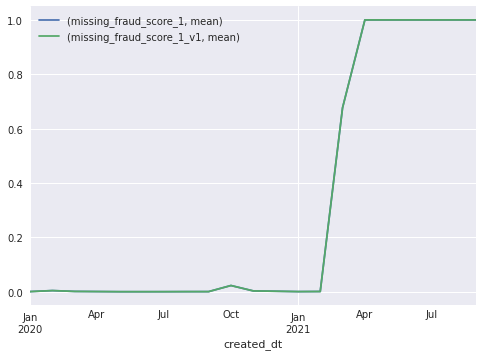

In [69]:
df_ = socure_df
df_[f"missing_fraud_score_1"] = df_["fraud_score_1"].isna() 
df_[f"missing_fraud_score_1_v1"] = df_["fraud_score_1_v1"].isna() 

df_ = df_.groupby(grouper)[["missing_fraud_score_1",
                            "missing_fraud_score_1_v1"]].agg(["mean", "sum", "count"])
df_.loc["2020-01-01":][("missing_fraud_score_1", "mean")].plot()
df_.loc["2020-01-01":][("missing_fraud_score_1_v1", "mean")].plot()
plt.legend()
display(df_.loc["2020-01-01":])

### Look at the final data

In [51]:
df = pd.read_feather("../../data/combined_all_features/combined_1632521410.feather")

<AxesSubplot:>

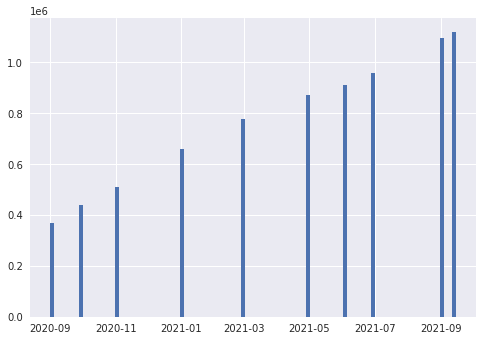

In [52]:
df[df.is_static].sample_date.hist(bins=100)

In [53]:
test_df = df[df.is_static]

/home/ec2-user/anaconda3/envs/customer_risk/lib/python3.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,mean,sum,count
sample_date,,,
2020-09-01,0.043651,16171,370460
2020-10-01,0.043057,18884,438581
2020-11-01,0.028546,14537,509245
2021-01-01,0.021168,13930,658068
2021-03-01,0.014961,11630,777372
2021-05-01,0.012293,10731,872938
2021-06-01,0.011499,10469,910416
2021-07-01,0.010393,9977,959994
2021-09-01,0.010570,11575,1095043


<AxesSubplot:xlabel='sample_date'>

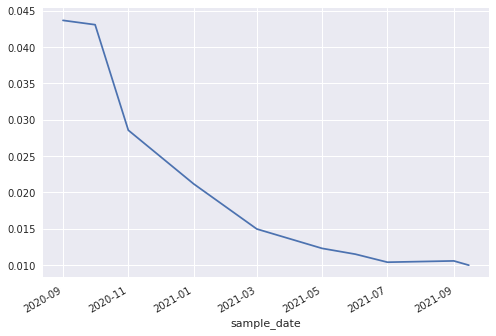

In [54]:
ft = "fraud_score_2"
# grouper = pd.Grouper(key='sample_date', freq="1M")
test_df[f"missing_{ft}"] = test_df[ft].isna() 
df_ = test_df.groupby("sample_date")[f"missing_{ft}"].agg(["mean", "sum", "count"])
display(df_)
df_["mean"].plot()